Source: https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/ar.html#Calculate-baseline-error

In [ ]:
!pip install pytorch_lightning pytorch_forecasting

     |████████████████████████████████| 527 kB 5.3 MB/s 
     |████████████████████████████████| 113 kB 51.1 MB/s 
     |████████████████████████████████| 952 kB 48.7 MB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
     |████████████████████████████████| 397 kB 46.1 MB/s 
     |████████████████████████████████| 134 kB 49.8 MB/s 
     |████████████████████████████████| 829 kB 44.9 MB/s 
     |████████████████████████████████| 1.1 MB 13.7 MB/s 
     |████████████████████████████████| 308 kB 26.7 MB/s 
     |████████████████████████████████| 81 kB 6.3 MB/s 
     |████████████████████████████████| 210 kB 68.9 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 58.2 MB/s 
     |████████████████████████████████| 144 kB 47.1 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 113 kB 59.5 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |█████████████████

In [ ]:
import os
import warnings

from pytorch_lightning.loggers import TensorBoardLogger

warnings.filterwarnings("ignore")

os.chdir("./")

import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

**DATA PROCESSING**

In [ ]:
df = pd.read_json('./marsWeather_till_17_1_2022.json')

In [ ]:
df = df[df['max_temp'].notna()]


In [ ]:
df = df.sort_index(ascending=False, inplace=False)

In [ ]:
df.isna().sum()


id                     0
terrestrial_date       0
sol                    0
ls                     0
season                 0
min_temp               0
max_temp               0
pressure               0
wind_speed          2734
atmo_opacity           0
dtype: int64

In [ ]:
df['terrestrial_date']=pd.to_datetime(df['terrestrial_date'])

df['sol_normalized'] = (df['sol']-501)%30
df['month_normalized'] = ((df['sol']-501)/30).astype('int32')
df['time_idx'] = (df['sol']-501)
df['series'] = 2

In [ ]:
df=df[["month_normalized", "time_idx", "max_temp", "series","terrestrial_date"]]

In [ ]:
df["max_temp"]=df["max_temp"].astype(float)

In [ ]:
df.describe

<bound method NDFrame.describe of       month_normalized  time_idx  max_temp  series terrestrial_date
2740                 0         0     -28.0       2       2014-01-02
2739                 0         1     -30.0       2       2014-01-03
2738                 0         2     -28.0       2       2014-01-04
2737                 0         3     -29.0       2       2014-01-05
2736                 0         4     -29.0       2       2014-01-06
...                ...       ...       ...     ...              ...
4                   94      2848     -12.0       2       2022-01-07
3                   94      2849     -20.0       2       2022-01-08
2                   95      2850     -16.0       2       2022-01-09
1                   95      2851     -16.0       2       2022-01-10
0                   95      2852     -14.0       2       2022-01-11

[2734 rows x 5 columns]>

In [ ]:
data = generate_ar_data(seasonality=10.0, timesteps=58, n_series=47, seed=42)

In [ ]:
data['value'] = df["max_temp"]
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")

In [ ]:
data.describe

<bound method NDFrame.describe of       series  time_idx  value  static       date
0          0         0  -14.0       2 2020-01-01
1          0         1  -16.0       2 2020-01-02
2          0         2  -16.0       2 2020-01-03
3          0         3  -20.0       2 2020-01-04
4          0         4  -12.0       2 2020-01-05
...      ...       ...    ...     ...        ...
2721      46        53  -24.0       2 2020-02-23
2722      46        54  -25.0       2 2020-02-24
2723      46        55  -29.0       2 2020-02-25
2724      46        56  -27.0       2 2020-02-26
2725      46        57  -25.0       2 2020-02-27

[2726 rows x 5 columns]>

In [ ]:
data = data[data['value'].notna()]


In [ ]:
data.isna().sum()

series      0
time_idx    0
value       0
static      0
date        0
dtype: int64

In [ ]:
# create dataset and dataloaders
max_encoder_length = 30
max_prediction_length = 10

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

In [ ]:
training_cutoff

47

In [ ]:
data.describe

<bound method NDFrame.describe of     series  time_idx  value  static       date
0        0         0  -24.0       2 2020-01-01
1        0         1  -26.0       2 2020-01-02
2        0         2  -25.0       2 2020-01-03
3        0         3  -27.0       2 2020-01-04
4        0         4  -27.0       2 2020-01-05
..     ...       ...    ...     ...        ...
79       3        16  -25.0       2 2020-01-17
80       3        17  -27.0       2 2020-01-18
81       3        18  -29.0       2 2020-01-19
82       3        19  -29.0       2 2020-01-20
83       3        20  -28.0       2 2020-01-21

[84 rows x 5 columns]>

In [ ]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"month_normalized": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=True,
)

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_e2522603-060a-49f9-a172-da7b46f47a4c.ckpt


suggested learning rate: 0.019952623149688802


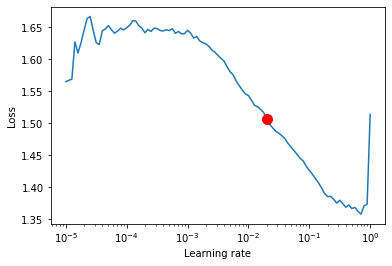

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

In [ ]:
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.594     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

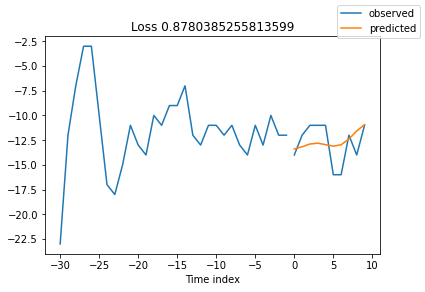

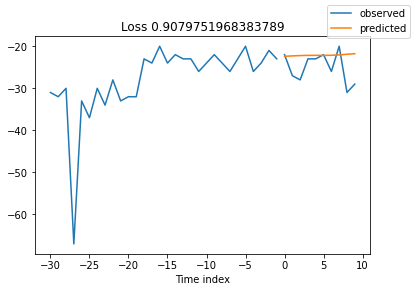

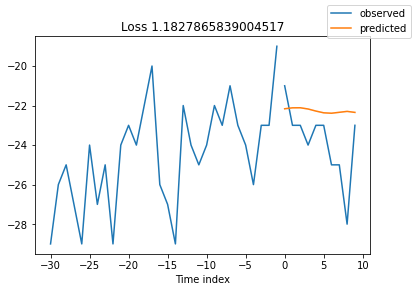

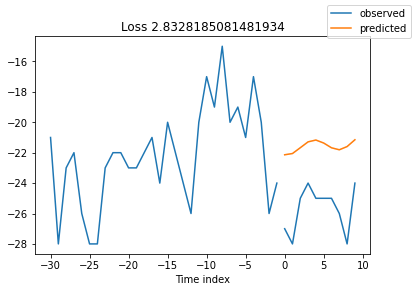

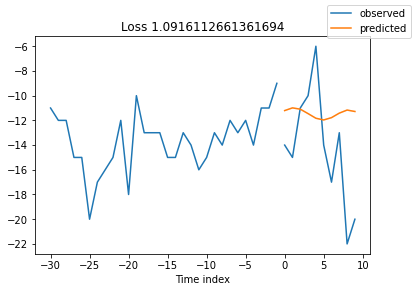

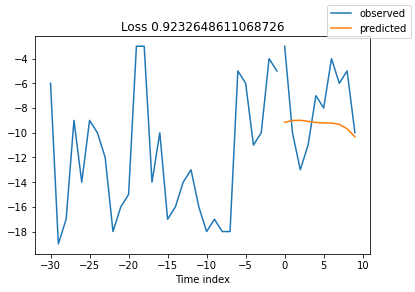

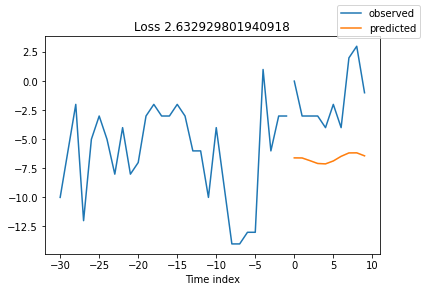

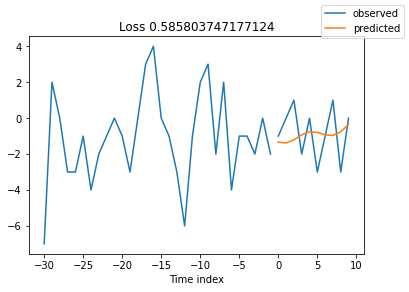

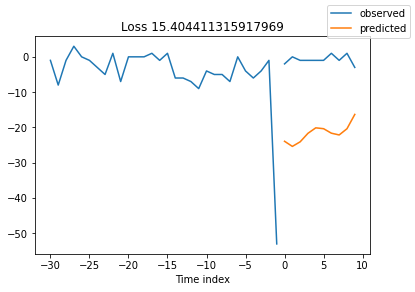

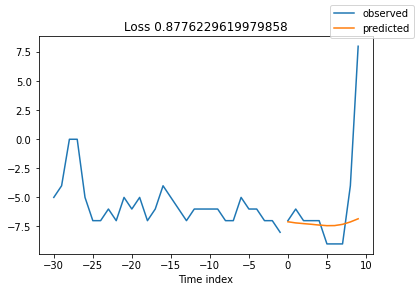

In [ ]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);


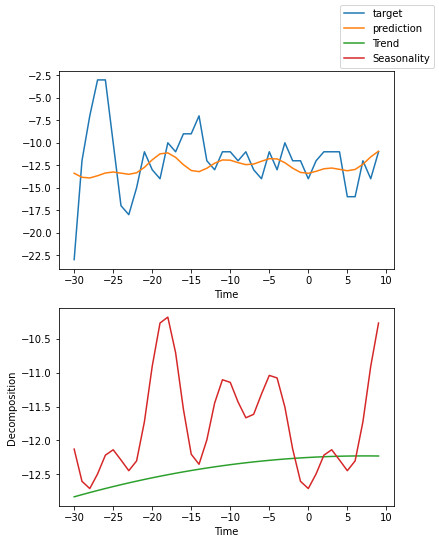

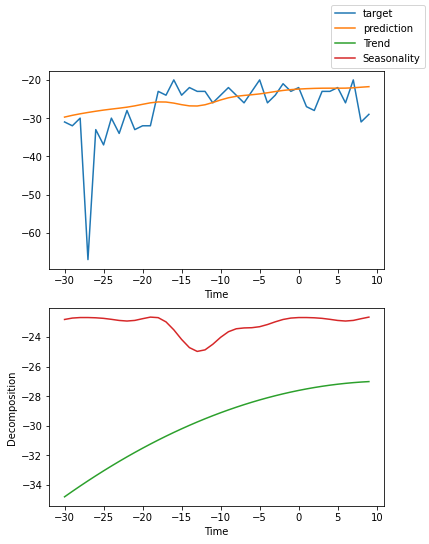

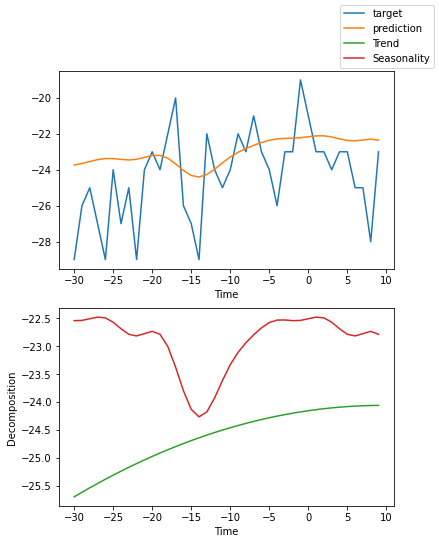

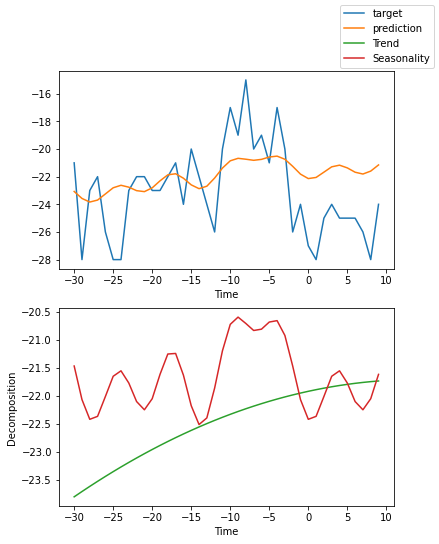

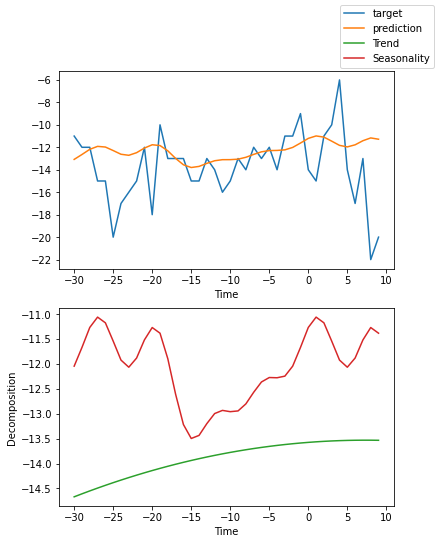

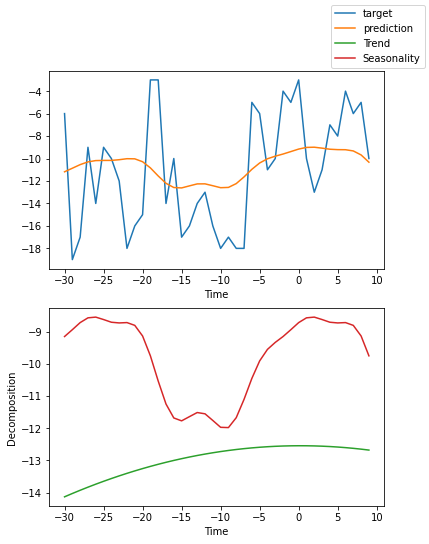

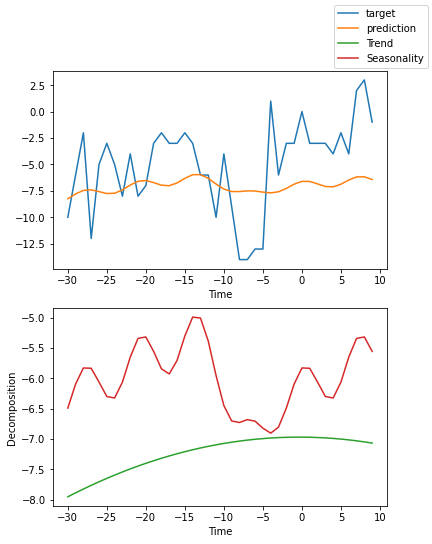

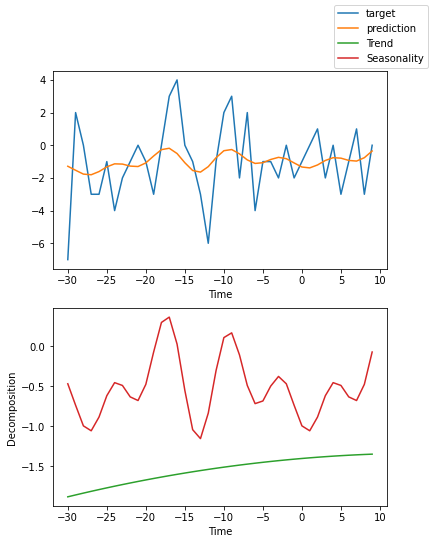

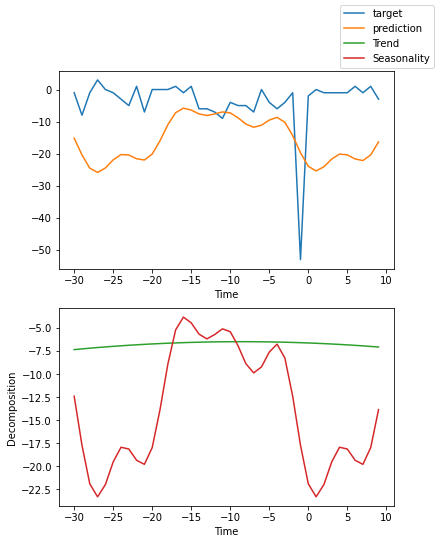

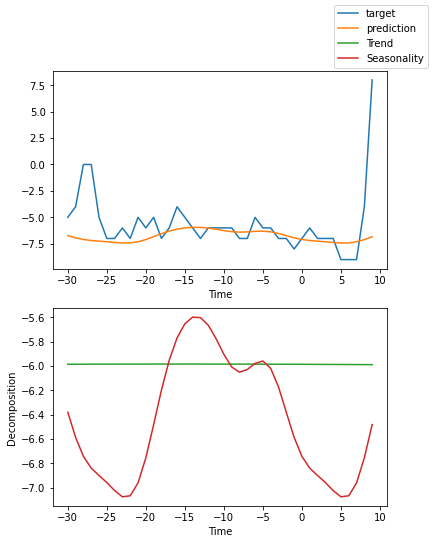

In [ ]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx);